In [2]:
from scipy.spatial import distance
import pickle
import torch
from torch import linalg
import numpy as np
from scipy.linalg import cho_solve
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

/Users/patricktourniaire/opt/miniconda3/envs/nmmm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_object(repo: str, file: str):
    # Path constant to save the object
    PATH = f'{repo}/{file}.pkl'

    with open(PATH, 'rb') as f:
        return pickle.load(f)

In [4]:
features = load_object('../../data/train', 'ring')
features = torch.from_numpy(features)

In [5]:
features

tensor([[ 4.8302,  1.7729],
        [-3.0147,  3.6299],
        [-2.7704, -4.4909],
        ...,
        [ 4.9549, -0.0193],
        [-3.0155, -3.9369],
        [ 5.2306,  0.5260]], dtype=torch.float64)

In [23]:
C = 1000
D = 2

means = torch.zeros(C, D, dtype=torch.float64).normal_(0, 2)

mu0 = means[0]
mu1 = means[1]

In [24]:
#L = torch.normal(2, 0.5, size=(C, 1, 1)) * torch.eye(D, D).view(1, D, D)
L = torch.normal(2, 0.5, size=(C, 2, 2)) 
sigmas = (L).type(torch.float64).contiguous()
print(sigmas[0])
print(torch.tril(sigmas[0]))
S0 = torch.tril(sigmas[0]) @ torch.tril(sigmas[0]).t()
S1 = torch.tril(sigmas[1]) @ torch.tril(sigmas[1]).t()

print(mu0, mu1, S0, S1)

tensor([[1.7208, 1.7744],
        [1.3891, 2.0949]], dtype=torch.float64)
tensor([[1.7208, 0.0000],
        [1.3891, 2.0949]], dtype=torch.float64)
tensor([ 1.9003, -2.7153], dtype=torch.float64) tensor([-0.9837, -1.1768], dtype=torch.float64) tensor([[2.9612, 2.3903],
        [2.3903, 6.3182]], dtype=torch.float64) tensor([[2.5793, 3.3567],
        [3.3567, 6.8345]], dtype=torch.float64)


In [25]:
def _sqrd_params(Si, Sj, mui, muj) -> torch.Tensor:
        # Compute the squared Gaussian params
        sigma = torch.inverse(torch.inverse(Si) + torch.inverse(Sj))
        mu = sigma @ (torch.inverse(Si) @ mui + torch.inverse(Si) @ muj)

        return (sigma, mu)

cluster_ids = torch.Tensor(range(C))
cartesian_ids = torch.cartesian_prod(cluster_ids, cluster_ids)
cartesian_ids = cartesian_ids.data.cpu().numpy().astype(int)

recomputed_params = {
    'means': [],
    'sigmas': []
}

for (i, j) in cartesian_ids:
    Si = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    Sj = torch.tril(sigmas[j]) @ torch.tril(sigmas[j]).t()
    
    sigma, mean = _sqrd_params(Si, Sj, means[i], means[j])
    
    recomputed_params['sigmas'].append(sigma.data.cpu().numpy())
    recomputed_params['means'].append(mean.data.cpu().numpy())

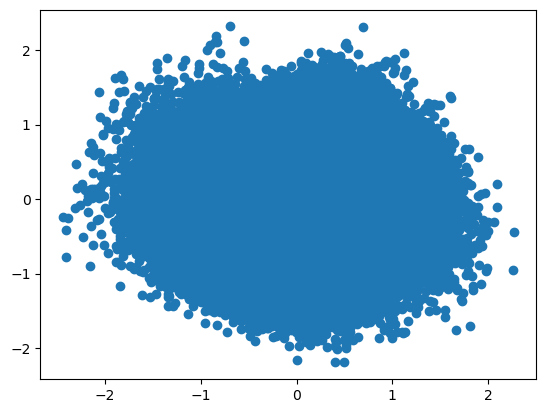

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.array(recomputed_params['means'])[:,0], np.array(recomputed_params['means'])[:,1])
plt.show()

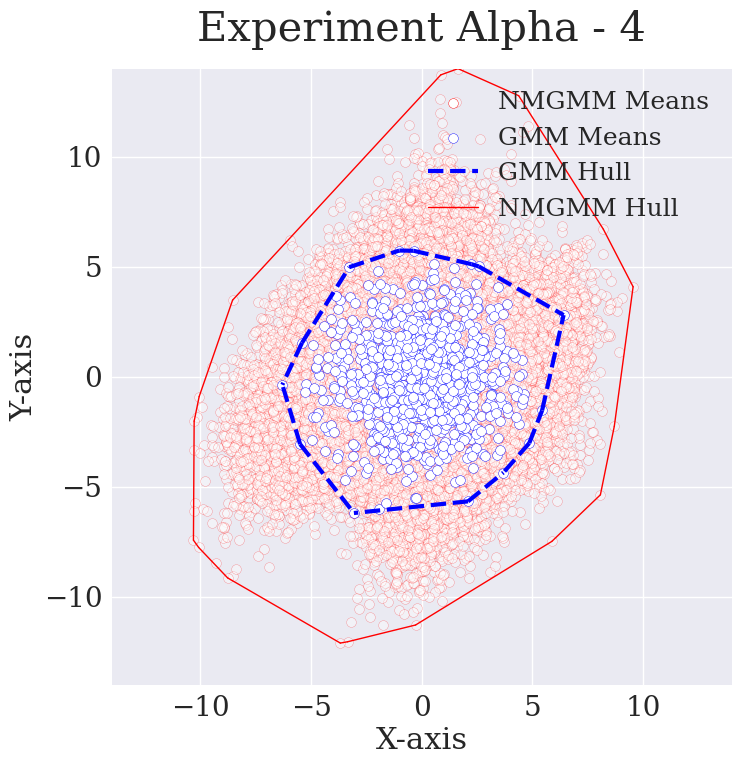

<Figure size 800x550 with 0 Axes>

In [26]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

plt.style.use('seaborn')


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 22,
    "font.size": 22,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 18,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 18
}

plt.rcParams.update(tex_fonts)


hull1 = ConvexHull(means)
hull2 = ConvexHull(np.array(recomputed_params['means']))

fig, ax = plt.subplots(figsize=(8,8))

ax.set_title(r'Experiment Alpha - 4', fontsize=30, pad=20)
ax.set_xlabel(r'X-axis')
ax.set_ylabel(r'Y-axis')
 
ax.set_xlim(-14, 14)
ax.set_ylim(-14, 14)

#ax.set_xlim(-4.5, 4.5)
#ax.set_ylim(-4.5, 4.5)

nmgmm_points = ax.scatter(
                np.array(recomputed_params['means'])[:,0],
                np.array(recomputed_params['means'])[:,1], 
                color='white',
                edgecolors='r',
                alpha=0.4,
                label='NMGMM Means')

gmm_points = ax.scatter(
                means[:,0], 
                means[:,1],
                color='white',
                edgecolors='blue',
                label='GMM Means')

for simplex in hull1.simplices:
    gmm_hull = ax.plot(
        means[simplex, 0],
        means[simplex, 1],
        'b--',
        linewidth=3,
        label='GMM Hull'
    )

for simplex in hull2.simplices:
    nmgmm_hull = ax.plot(
        np.array(recomputed_params['means'])[simplex, 0],
        np.array(recomputed_params['means'])[simplex, 1], 
        'r-',
        linewidth=1,
        label='NMGMM Hull'
    )

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), loc=1)

for lh in legend.legendHandles: 
    lh.set_alpha(1)

plt.show()
plt.draw()
fig.savefig('convexhull_mean_translations_alpha4.png', format='png', bbox_inches='tight')

In [133]:
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

def _confidence_ellipse(ax, sigma, mu, n_std=2.3, facecolor='none', **kwargs):
        pearson = sigma[0][1]/np.sqrt(sigma[0][0] * sigma[1][1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(sigma[0][0]) * n_std
        mean_x = mu[0]

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(sigma[1][1]) * n_std
        mean_y = mu[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def plot_contours(means, sigmas):
        _, ax = plt.subplots()

        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)

        for i in range(C):
            sigma = sigmas[i]
            mu = means[i]
            
            config = {
                'alpha': .2
            }

            _confidence_ellipse(ax, sigma, mu, **config)
            ax.scatter(mu[0], mu[1], c='red', s=3)
        
        plt.plot()

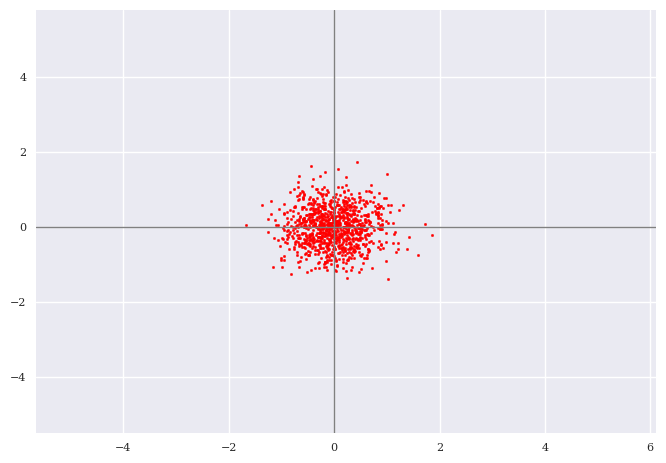

In [121]:
plot_contours(means.data.cpu().numpy(), sigmas.data.cpu().numpy())

In [27]:
sqrd_gen_variance = []

for i in range(C):
    S = recomputed_params['sigmas'][i]
    sqrd_gen_variance.append(np.linalg.det(S))

sqrd_gen_variance = np.array(sqrd_gen_variance)
sqrd_gen_variance

array([3.24896041, 2.07472073, 2.78093348, 3.77763924, 5.09090056,
       4.11483244, 2.40179754, 4.39079381, 0.8731245 , 3.12290276,
       3.97467544, 2.66097032, 4.10281786, 0.72923856, 2.21378186,
       3.5395319 , 3.41929565, 2.48515313, 4.41839596, 1.17552813,
       3.37148741, 2.32732344, 1.29344121, 2.67878285, 2.05823173,
       2.54975845, 1.25763344, 1.66585596, 5.22796422, 1.93588277,
       2.66156735, 4.78606613, 2.08807529, 2.20627878, 1.17564626,
       0.61386925, 3.83371159, 3.10737182, 3.32573189, 2.33149312,
       5.05406968, 4.02676962, 2.7094572 , 3.6133911 , 3.3764464 ,
       3.25769765, 1.83189038, 2.965464  , 4.69020961, 4.08090684,
       3.26299638, 2.51099884, 4.29096116, 4.24992059, 3.39573547,
       4.16642043, 2.86081447, 0.74248087, 2.56523799, 4.05370824,
       1.12667634, 2.33277317, 1.50906869, 1.47017976, 2.72403739,
       2.35548093, 4.11914837, 1.36379212, 4.59204771, 2.54463743,
       2.37768006, 4.21796645, 3.4159582 , 1.84168511, 1.77103

In [28]:
gen_variance = []

for i in range(C):
    S = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    S = S.data.cpu().numpy()
    
    gen_variance.append(np.linalg.det(S))

gen_variance = np.array(gen_variance)
gen_variance

array([12.99584165,  6.36100186, 11.74833795, 18.4656171 , 38.27712636,
       24.8336925 ,  8.27327997, 25.68879151,  3.80143055, 12.13082534,
       21.33384251, 11.03963388, 22.39670152,  2.27991425,  8.25824106,
       16.43242392, 15.42655609,  8.94547695, 28.26247782,  2.98915326,
       15.9531661 ,  8.25914463,  2.84227682, 10.9579204 ,  8.02163526,
       11.72487402,  3.69698495,  5.67437428, 39.99898139,  5.39439901,
       10.98178236, 31.4331564 , 10.47076892,  6.99405298,  3.40733289,
        1.53419825, 21.70032052, 12.87711864, 14.8563889 , 10.37726844,
       40.87355978, 20.75150656,  9.61599781, 16.76769556, 17.2844163 ,
       16.42326093,  5.92503738, 11.45775742, 31.89155801, 23.70396108,
       14.05675418,  9.66758528, 24.71448064, 23.91216808, 16.08053511,
       24.36305987, 13.70110155,  1.95426579,  9.46035067, 23.96207842,
        2.93549023,  9.57504045,  3.87310644,  4.37460467,  9.93028214,
       10.79493458, 24.41099207,  4.83153209, 34.36917349,  8.91

<BarContainer object of 2 artists>

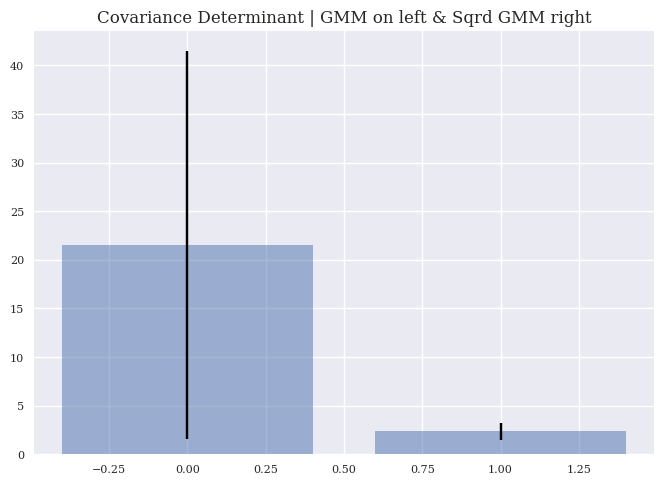

In [136]:
plt.title('Covariance Determinant | GMM on left & Sqrd GMM right')
plt.bar((0, 1), (gen_variance.mean(), sqrd_gen_variance.mean()), yerr=(gen_variance.std(), sqrd_gen_variance.std()), align='center', alpha=0.5)



In [44]:
print(sqrd_gen_variance.mean() - gen_variance.mean())

-18.45976386509063


[<matplotlib.patches.Patch object at 0x7fbceb89e9e0>, <matplotlib.patches.Patch object at 0x7fbceb89e9e0>]


<Figure size 800x550 with 0 Axes>

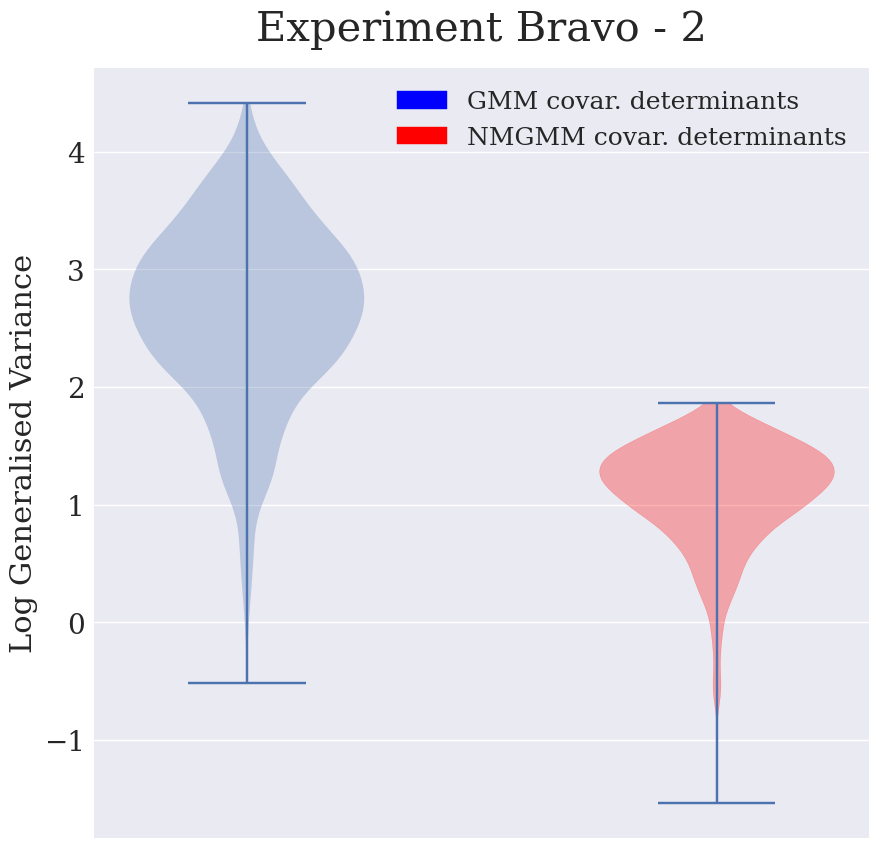

<Figure size 800x550 with 0 Axes>

In [29]:
import matplotlib.patches as mpatches
from itertools import repeat

plt.style.use('seaborn')


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 22,
    "font.size": 22,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 18,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 18
}

plt.rcParams.update(tex_fonts)

fig = plt.figure()

# Create an axes instance
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([], [])

ax.set_title('Experiment Bravo - 2', fontsize=30, pad=20)
ax.set_ylabel('Log Generalised Variance')


red_patch = mpatches.Patch(color='red')
# 'fake' invisible object

pos   = [1, 2]
label = ['GMM covar. determinants','NMGMM covar. determinants']

fake_handles = repeat(red_patch, len(pos))
print(list(fake_handles))

# Create the boxplot
violin_parts = ax.violinplot([np.log(gen_variance), np.log(sqrd_gen_variance)])
violin_parts['bodies'][1].set_facecolor('red')
violin_parts['bodies'][1].set_edgecolor('red')


ax.legend([mpatches.Patch(color='blue'), mpatches.Patch(color='red')], label)

plt.show()
plt.draw()
fig.savefig('generalised_variance_log_bravo2.png', format='png', bbox_inches='tight')

In [ ]:
import matplotlib.patches as mpatches
from itertools import repeat
    
fig = plt.figure()

# Create an axes instance
fig, ax = plt.subplots(figsize=(8,6))
ax.set_yticks([], [])

ax.set_title('2D Generalised Variance')
ax.set_xlabel('Generalised variance (Sigma determinant)')


red_patch = mpatches.Patch(color='red')
# 'fake' invisible object

pos   = [1, 2]
label = ['GMM covar. determinants','NMGMM covar. determinants']

fake_handles = repeat(red_patch, len(pos))
print(list(fake_handles))

# Create the boxplot
violin_parts = ax.violinplot([gen_variance, sqrd_gen_variance], vert=False)
violin_parts['bodies'][1].set_facecolor('red')
violin_parts['bodies'][1].set_edgecolor('red')


ax.legend([mpatches.Patch(color='blue'), mpatches.Patch(color='red')], label)

plt.show()
plt.draw()
fig.savefig('generalised_variance.png')